In [ ]:
import pandas as pd
import torch

#grab data from working directory
main_data = pd.read_csv('data.csv')
training_data = pd.read_csv('training_data.csv')
validation_data = pd.read_csv('validation_data.csv')

In [ ]:
dtype = torch.float
ltype = torch.long

if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

# Constant to control how frequently we print train loss

print('using device:', device)

using device: cuda:0


In [ ]:
# prompt: write 2 data preprocessing functions
# the first one filters out all rows that have an empty 'problem_tags' column or have the problem_tags column include "*specialproblem". it also filters out all rows that have empty problem_statement columns
# the second function will split the problem_tags column and split it into two columns. the first resulting column will just be the original problem_tags column and the second resulting column will be rating.
# the problem tags column is originally a comma seperated list and should include some value that looks like *2400 or *2300 or *900, these values are ratings. there should be only one of them, take the rating value and put it in the rating column. if there is a problem with no rating value in its 'problem_tags' column it should be filtered out

def preprocess_data_1(df):
  """
  Filters out rows with empty 'problem_tags' or 'problem_statement' columns,
  and rows where 'problem_tags' contains '*specialproblem'.
  """
  df = df.dropna(subset=['problem_tags', 'problem_statement'])
  df = df[~df['problem_tags'].str.contains(r"\*specialproblem", na=False)]
  return df

def preprocess_data_2(df):
  """
  Splits the 'problem_tags' column into two columns: 'problem_tags' (original)
  and 'rating'. Extracts the rating value from the 'problem_tags' column if
  it exists, otherwise filters out the row.
  """
  def extract_rating(tags):
    if isinstance(tags, str):
      for tag in tags.split(','):
        if '*' in tag and tag.replace('*', '').isdigit():
          return int(tag.replace('*', ''))
    return None

  df.loc[:, 'rating'] = df['problem_tags'].apply(extract_rating)

  #drop rows with no rating
  df = df.dropna(subset=['rating'])

  for i in range(len(df)):
    good_tags = []
    for tag in df.iloc[i]['problem_tags'].split(','):
      if '*' not in tag and tag.split():
        good_tags.append(tag)
    df.loc[df.index[i], 'problem_tags'] = ','.join(good_tags)

  #drop problems with empty string for tags
  df = df[df['problem_tags'] != '']

  return df

main_data = preprocess_data_1(main_data)
main_data = preprocess_data_2(main_data)
training_data = preprocess_data_1(training_data)
training_data = preprocess_data_2(training_data)
validation_data = preprocess_data_1(validation_data)
validation_data = preprocess_data_2(validation_data)

<ipython-input-4-39eb564d6f9e>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rating'] = df['problem_tags'].apply(extract_rating)


In [ ]:

n = 25  # Hyperparameter for the number of most frequent tags

all_tags = []
for tags in main_data['problem_tags'].dropna():
    all_tags.extend(tags.split(','))

from collections import Counter

tag_counts = Counter(all_tags)
most_frequent_tags = set([tag for tag, count in tag_counts.most_common(n)])

print(f"The {n} most frequent tags are: {most_frequent_tags}")

The 25 most frequent tags are: {'hashing', 'probabilities', 'constructivealgorithms', 'geometry', 'greedy', 'sortings', 'games', 'strings', 'dfsandsimilar', 'interactive', 'graphs', 'datastructures', 'numbertheory', 'shortestpaths', 'binarysearch', 'divideandconquer', 'bruteforce', 'twopointers', 'dp', 'bitmasks', 'combinatorics', 'dsu', 'implementation', 'trees', 'math'}


In [ ]:
# prompt: what percent of problems use a tag found in the n most common ?

problems_with_top_n_tags = 0
total_problems = len(main_data)

for tags in main_data['problem_tags'].dropna():
  if isinstance(tags, str):
    for tag in tags.split(','):
      if tag in most_frequent_tags:
        problems_with_top_n_tags += 1
        break  # Only count the problem once if it has at least one top-n tag

percentage = (problems_with_top_n_tags / total_problems) * 100
print(f"Percentage of problems with at least one of the top {n} tags: {percentage:.2f}%")

Percentage of problems with at least one of the top 25 tags: 99.45%


In [ ]:
# prompt: now make a function that takes  the string from problem tags, and returns a pytorch vector of floats length n, where a[i] is 1 iff the ith most frequent problem tag is in the list
# also make a function that takes a rating and computes its zscore when the mean rating is 1500 and the standard deviation is 300
# make an inverse of that function as well
from transformers import BertTokenizer

def problem_tags_to_vector(tags_string, most_frequent_tags, n):
  """
  Converts a string of problem tags to a PyTorch vector of length n.

  Args:
    tags_string: A string of problem tags separated by commas.
    most_frequent_tags: A set of the n most frequent problem tags.
    n: The length of the vector.

  Returns:
    A PyTorch vector of floats, where a[i] is 1 if the ith most frequent
    problem tag is present in the tags_string, and 0 otherwise.
  """
  if not isinstance(tags_string, str):
    return torch.zeros(n)
  tags = set(tags_string.split(','))
  vector = [1.0 if tag in tags else 0.0 for tag in most_frequent_tags]
  return torch.tensor(vector, dtype=torch.float32)

def rating_to_zscore(rating):
  """Computes the z-score of a rating."""
  mean_rating = 1500
  std_rating = 300
  return (rating - mean_rating) / std_rating

def zscore_to_rating(zscore):
  """Computes the rating from a z-score."""
  mean_rating = 1500
  std_rating = 300
  return (zscore * std_rating) + mean_rating

MAXLEN = 512
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
def tokenize_text(text):
  return tokenizer(text, padding='max_length', truncation=True, max_length=MAXLEN)


#TODO
#MOVE THIS TO A MORE SENSIBLE AREA

In [ ]:
from transformers import BertModel
from torch.utils.data import Dataset
import torch.nn.init as init
import torch.nn as nn

class MultiTaskModel(nn.Module):
    def __init__(self):
        super(MultiTaskModel, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.rating_classifier = nn.Linear(768, 1)  # For regression or binary classification
        self.tag_classifier = nn.Linear(768, n)  # Multi-label classification

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        rating_pred = self.rating_classifier(pooled_output)
        tag_pred = self.tag_classifier(pooled_output)
        return rating_pred, tag_pred

class TagModel(nn.Module):
    def __init__(self):
        super(TagModel, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.tag_classifier = nn.Linear(768, n)  # Multi-label classification

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        tag_pred = self.tag_classifier(pooled_output)
        return tag_pred

def init_weights(m):
    if isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

class CustomDataset(Dataset):
    def __init__(self, input_ids, attention_mask, ratings, tags, device):
        self.input_ids = input_ids.to(device)
        self.attention_mask = attention_mask.to(device)
        self.ratings = ratings.to(device)
        self.tags = tags.to(device)

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attention_mask[idx], self.ratings[idx], self.tags[idx]

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

texts = training_data['problem_statement'].tolist()
encodings = tokenizer(texts, truncation=True, padding=True, max_length=MAXLEN)

tags = training_data['problem_tags'].tolist()
tags = [problem_tags_to_vector(tag, most_frequent_tags, n) for tag in tags]

ratings = training_data['rating'].tolist()
ratings = [rating_to_zscore(rating) for rating in ratings]

input_ids = torch.tensor(encodings['input_ids'])
attention_mask = torch.tensor(encodings['attention_mask'])
ratings = torch.tensor(ratings, dtype=torch.float32)

tags = torch.stack(tags)

#validation stuff
val_texts = validation_data['problem_statement'].tolist()
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=MAXLEN)

val_tags = validation_data['problem_tags'].tolist()
val_tags = [problem_tags_to_vector(tag, most_frequent_tags, n) for tag in val_tags]

val_ratings = validation_data['rating'].tolist()
val_ratings = [rating_to_zscore(rating) for rating in val_ratings]

val_input_ids = torch.tensor(val_encodings['input_ids'])
val_attention_mask = torch.tensor(val_encodings['attention_mask'])
val_ratings = torch.tensor(val_ratings, dtype=torch.float32)

val_tags = torch.stack(val_tags)


bsz = 32
val_dataset = CustomDataset(val_input_ids, val_attention_mask, val_ratings, val_tags, device)
val_loader = DataLoader(val_dataset, batch_size=bsz, shuffle=True)
dataset = CustomDataset(input_ids, attention_mask, ratings, tags, device)
loader = DataLoader(dataset, batch_size=bsz, shuffle=True)

In [ ]:
import matplotlib.pyplot as plt
from IPython import display
import torch.optim as optim
from tqdm import tqdm

rating_losses = []
tag_losses = []
total_losses = []

model = TagModel()
model.apply(init_weights)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
model.train()

ratingw = 0.1
tagw = 1

for epoch in range(3):
    loop = tqdm(loader, leave=True) # wrap the dataloader with tqdm
    for batch_idx, batch in enumerate(loop):
        input_ids, attention_mask, rating_labels, tag_labels = batch

        optimizer.zero_grad()
        tag_pred = model(input_ids=input_ids, attention_mask=attention_mask)

        loss = nn.BCEWithLogitsLoss()(tag_pred, tag_labels)

        # rating_losses.append(rating_loss.item())
        # tag_losses.append(tag_loss.item())
        total_losses.append(loss.item())

        loss.backward()
        optimizer.step()

        # Update progress bar description
        loop.set_description(f"Epoch [{epoch + 1}/3]")
        loop.set_postfix(tag_loss=loss.item())

    #try validation set
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for batch_idx, batch in enumerate(val_loader):
            input_ids, attention_mask, rating_labels, tag_labels = batch
            tag_pred = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = nn.BCEWithLogitsLoss()(tag_pred, tag_labels)
            val_loss += loss.item()
            # Update progress bar description
            loop.set_description(f"Epoch [{epoch + 1}/3]")
            loop.set_postfix(val_loss=loss.item())
        val_loss /= len(val_loader)
    print(f"Epoch {epoch + 1} completed.")
    print(f"Validation loss: {val_loss}")
    model.train()


Epoch [1/3]: 100%|██████████| 371/371 [09:03<00:00,  1.47s/it, tag_loss=0.308]


Epoch 1 completed.
Validation loss: 0.29987896820332144


Epoch [2/3]: 100%|██████████| 371/371 [09:02<00:00,  1.46s/it, tag_loss=0.292]


Epoch 2 completed.
Validation loss: 0.3007832740215545


Epoch [3/3]:  18%|█▊        | 68/371 [01:39<07:25,  1.47s/it, tag_loss=0.375]

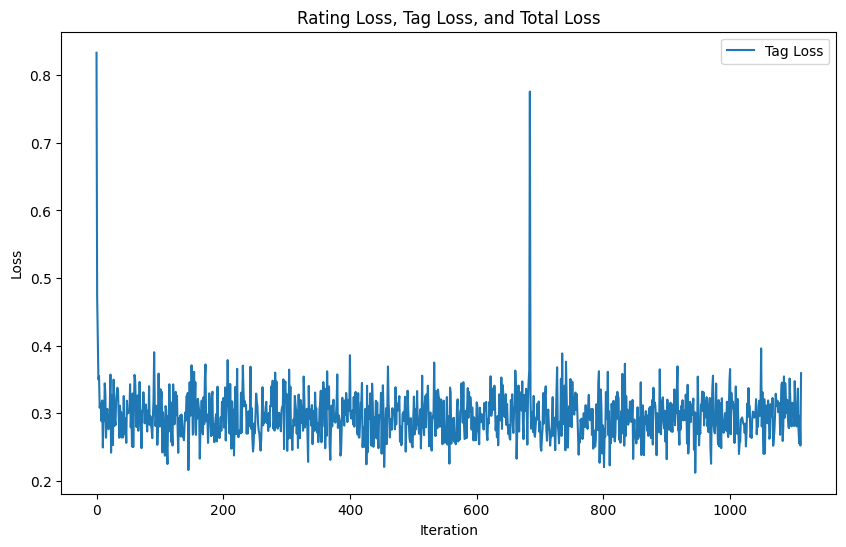

In [ ]:
# prompt: make one chart plotting rating loss and tag loss and their sum

plt.figure(figsize=(10, 6))
# plt.plot(rating_losses, label='Rating Loss')
plt.plot(total_losses, label='Tag Loss')
# plt.plot([x + y for x, y in zip(rating_losses, tag_losses)], label='Total Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Rating Loss, Tag Loss, and Total Loss')
plt.legend()
plt.show()

In [ ]:
# prompt: write a function that takes in text then runs the model to infer what tags it has the prints out each tag name and its associated probability

def infer_tags(text, model, tokenizer, most_frequent_tags, device, threshold=0.5):
  """
  Infers tags for a given text using the trained model.

  Args:
    text: The input text.
    model: The trained model.
    tokenizer: The tokenizer used for the model.
    most_frequent_tags: A list of the most frequent tags.
    device: The device (CPU or GPU) to use.
    threshold: The probability threshold for considering a tag to be present.

  Returns:
    A list of tuples, where each tuple contains a tag name and its probability.
  """

  model.eval()  # Set the model to evaluation mode
  with torch.no_grad():
    inputs = tokenizer(text, truncation=True, padding=True, max_length=MAXLEN, return_tensors="pt").to(device)
    tag_pred = model(**inputs)
    tag_probs = torch.sigmoid(tag_pred)  # Apply sigmoid to get probabilities

    tag_probs = tag_probs.cpu().numpy().tolist()[0]  # Convert to list

    tag_results = []
    for i, prob in enumerate(tag_probs):
      if prob >= threshold:
        tag_results.append((list(most_frequent_tags)[i], prob))

    return tag_results



# Example usage:
text_to_infer = "Write a function to calculate the sum of two numbers."
tag_results = infer_tags(text_to_infer, model, tokenizer, most_frequent_tags, device)

for tag, prob in tag_results:
  print(f"Tag: {tag}, Probability: {prob:.4f}")